In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import myUtils
import EfficientNet
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from GTSRB_utils import GTSRB_CLASSES, predict_traffic_sign, create_subset_loader, load_ppm_image
from uap_attack import generate_uap, apply_uap
from deep_fool import deepfool_attack


2025-03-22 22:37:01.993389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 22:37:02.020458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 22:37:02.029225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 22:37:02.048221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 22:37:03.644863: W tensorflow/compiler/tf2

Padding needed: (2, 2)


In [3]:
from tensorflow.keras.models import load_model
model = load_model("TrafficSigns_EfficientNetB1.keras")

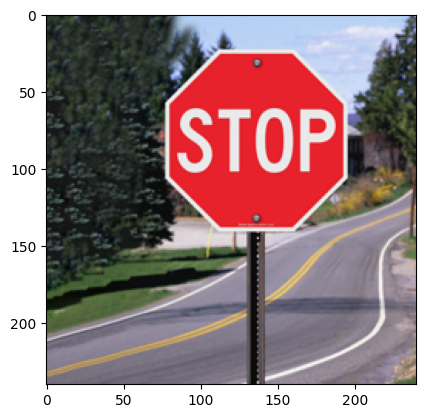

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction shape: (1, 43)
Predicted class: Stop
True Prediction:  Stop


In [10]:

# Path to your .ppm image
image_path = "stop.jpg"

# Load and preprocess the image with the correct target size (240x240)
image = load_ppm_image(image_path, target_size=(240, 240))
image_to_show = tf.squeeze(image, axis=0)
plt.imshow(image_to_show/255.0)
plt.show()
true_pridition  = predict_traffic_sign(image, model, GTSRB_CLASSES)
print("True Prediction: ", GTSRB_CLASSES[true_pridition])

Below is an example of a Markdown documentation file (README.md) that explains the implementations of DeepFool and SparseFool attacks and includes references to the original papers.

---

# DeepFool and SparseFool Attack Implementations

This repository contains TensorFlow 2.x implementations of two adversarial attack methods:
- **DeepFool** – An untargeted attack that finds minimal perturbations to fool a classifier.
- **SparseFool** – A sparse attack that builds on DeepFool to produce perturbations that alter as few pixels as possible.

Both implementations target image classification models (e.g., EfficientNet) and can be applied to single images.

---

## Table of Contents

- [Overview](#overview)
- [DeepFool Attack](#deepfool-attack)
  - [Reference Paper](#reference-paper-for-deepfool)
  - [Usage](#usage-of-deepfool)
- [SparseFool Attack](#sparsefool-attack)
  - [Reference Paper](#reference-paper-for-sparsefool)
  - [Methodology](#methodology)
  - [Usage](#usage-of-sparsefool)
- [Requirements](#requirements)
- [License](#license)

---

## Overview

Adversarial attacks expose vulnerabilities in deep neural networks by applying carefully crafted perturbations to input data. The **DeepFool** algorithm (Moosavi-Dezfooli et al., 2016) computes minimal \( \ell_2 \) perturbations that cause misclassification by iteratively linearizing the classifier's decision boundary. **SparseFool** (Modas et al., 2019) builds on DeepFool by finding a sparse (i.e., few pixel) perturbation that remains effective, which is particularly relevant for tasks where only minimal changes should occur.

---

## DeepFool Attack

### Reference Paper for DeepFool

- **DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks**  
  S.-M. Moosavi-Dezfooli, A. Fawzi, and P. Frossard, CVPR 2016  
  [arXiv:1511.04599](https://arxiv.org/abs/1511.04599)

### Usage of DeepFool

The `deepfool_attack_single` function implements DeepFool for a single image. It returns both the adversarial image and the perturbation applied.

Example:
```python
# Assuming you have a Keras classification model 'model',
# a preprocessed single image 'image' of shape [H, W, C] with pixel values in [0,1],
# and its true class label 'true_label' (an integer).
adv_image, r_adv = deepfool_attack_single(model, image, true_label, max_iter=50, overshoot=0.02)

# To visualize:
import matplotlib.pyplot as plt
plt.imshow(adv_image.numpy())
plt.title("Adversarial Image (DeepFool)")
plt.show()
```

*Note:* Ensure that your image is normalized as required by your model (e.g., EfficientNet often expects inputs scaled to [0, 1]).

---

## SparseFool Attack

### Reference Paper for SparseFool

- **SparseFool: A Few Pixels Make a Big Difference**  
  Apostolos Modas, Seyed-Mohsen Moosavi-Dezfooli, Pascal Frossard, CVPR 2019  
  [arXiv:1811.02248](https://arxiv.org/abs/1811.02248)

### Methodology

SparseFool refines the adversarial perturbation found by DeepFool into a sparse perturbation by:
1. **Initial Adversarial Example:**  
   Running DeepFool to obtain a perturbation \( r_{\text{adv}} \) so that \( x_B = x + r_{\text{adv}} \) lies near the decision boundary.
2. **Estimating the Decision Boundary Normal:**  
   Computing the gradient at \( x_B \) to obtain the normal vector \( w \).
3. **Iterative Coordinate-Wise Updates:**  
   Updating one coordinate at a time:
   - **Select Coordinate:** Choose the coordinate with the largest absolute gradient value that isn’t saturated.
   - **Compute Perturbation:** Use the formula
     \[
     r_d = \frac{|w^T(x_{\text{current}} - x_B)|}{|w_d|} \cdot \text{sign}(w_d)
     \]
     to determine the minimal update needed along that coordinate.
   - **Apply Projection:** Update \( x_{\text{current}} \) with the computed perturbation and ensure the updated image stays within valid bounds.
   - **Accumulate Perturbation:** Add each coordinate update to the total perturbation \( r_{\text{total}} \).
   - **Stop When Misclassified:** Continue until the classifier misclassifies \( x_{\text{current}} \).

### Usage of SparseFool

Below is an example of how to use the `sparse_fool_attack` function on a single image:

```python
# Assuming you have a Keras classification model 'model',
# a preprocessed single image 'image' of shape [H, W, C],
# and its true label 'true_label'.

adv_im, r_total = sparse_fool_attack(model, image, true_label, 
                                       deepfool_max_iter=20, 
                                       sparse_max_iter=20, 
                                       overshoot=0.02)

# Visualize the adversarial image
import matplotlib.pyplot as plt
plt.imshow(adv_im.numpy())
plt.title("Adversarial Image (SparseFool)")
plt.show()

# Visualize the sparse perturbation (scale if needed)
plt.imshow(tf.clip_by_value(r_total * 50, 0, 1).numpy())
plt.title("Scaled Sparse Perturbation")
plt.show()

# To get prediction of the adversarial example:
adv_prediction = tf.argmax(model(tf.expand_dims(adv_im, axis=0), training=False), axis=1).numpy()[0]
print("Adversarial Prediction: ", adv_prediction)
```



## References

1. **DeepFool:**  
   Moosavi-Dezfooli, S.-M., Fawzi, A., & Frossard, P. (2016). DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks. In *CVPR 2016*. [arXiv:1511.04599](https://arxiv.org/abs/1511.04599)

2. **SparseFool:**  
   Modas, A., Moosavi-Dezfooli, S.-M., & Frossard, P. (2019). SparseFool: A Few Pixels Make a Big Difference. In *CVPR 2019*. [arXiv:1811.02248](https://arxiv.org/abs/1811.02248)





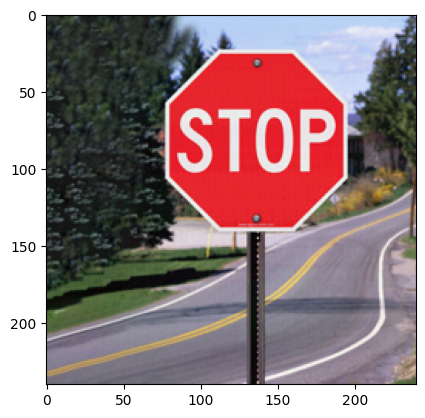

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
Prediction shape: (1, 43)
Predicted class: Keep right
Adversarial Prediction:  Keep right


In [11]:
image = image / 255.0
adv_tensor_fool,r_fool= deepfool_attack(model, image, true_pridition, max_iter=20, overshoot=0.02)
adv_im = tf.squeeze(adv_tensor_fool, axis=0)
plt.imshow(adv_im)
plt.show()
adv_prediction = predict_traffic_sign(adv_tensor_fool, model, GTSRB_CLASSES)
print("Adversarial Prediction: ", GTSRB_CLASSES[adv_prediction])

In [12]:
from sparsefool import sparse_fool_attack

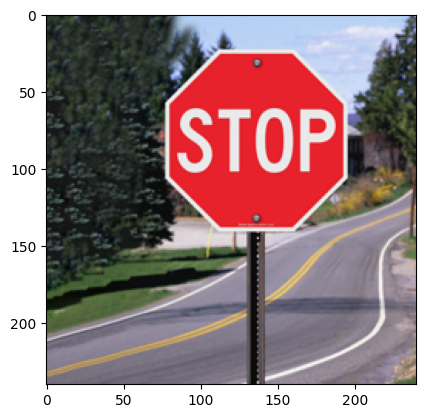

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
Prediction shape: (1, 43)
Predicted class: Keep right
Adversarial Prediction:  Keep right


In [13]:
sparse_tensor , r_sparse = sparse_fool_attack(model, image, true_pridition
                                       ,deepfool_max_iter=20, sparse_max_iter=20, overshoot=0.02)
image = image / 255.0
adv_im_sparse = tf.squeeze(sparse_tensor, axis=0)
plt.imshow(adv_im_sparse)
plt.show()
adv_prediction_sparse = predict_traffic_sign(sparse_tensor, model, GTSRB_CLASSES)
print("Adversarial Prediction: ", GTSRB_CLASSES[adv_prediction])

In [16]:
print(f"min r_fool: {np.min(r_fool):.8f}")
print(f"max r_fool: {np.max(r_fool):.8f}")
print(f"min r_sparse: {np.min(r_sparse):.8f}")
print(f"max r_sparse: {np.max(r_sparse):.8f}")


min r_fool: -0.02000000
max r_fool: 0.02000000
min r_sparse: 0.00000000
max r_sparse: 0.00000000
